In [1]:
# Third-party Library Imports
import pandas as pd
import numpy as np
import itertools
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from bias_correction import BiasCorrection
from sklearn.metrics import (
    r2_score,
    mean_squared_error as mse,
)
from scipy.stats import pearsonr
from scipy.stats import gamma, norm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.set_option('display.max_columns', 100)

### 1. Read SCM & ERA data

In [3]:
era_regional = pd.read_csv("files/ERA/processed/era_regional.csv")
regions_shape = gpd.read_file("files/shapefiles/study_region_v2.shp")

features_raw = [ 'rain_8', 'rain_9', 'rain_10', 'rain_11', 'tmean_8', 'tmean_9', 'tmean_10', 'tmean_11']
era_regional = era_regional[["model", "region", "year", "init_month"] + features_raw]
# Read SCM data 
c3s = pd.read_csv("c3s/data/c3s_hindcasts_ensembles.csv")
nmme = pd.read_csv("nmme/data/nmme_hindcasts.csv")
scm = pd.concat([c3s, nmme], ignore_index=True).drop_duplicates().rename(columns={"forecasted_month":"month"})

scm["rain"] = scm["rain"].apply(lambda x: x*1000)

# Filter SCM data by month and model
scm = scm.loc[(scm["year"].between(1993, 2016)) & (scm["init_month"].between(6, 11) & (scm["model"].isin(['GFDL', 'CCSM4', 'NASA', 'CMCC', 'DWD', 'ECMWF', 'METFR', 'UKMO', 'ECCC', 'NCEP'])))].reset_index(drop=True)

# Filter SCM data by grid cells of study region
scm = gpd.GeoDataFrame(scm, geometry=gpd.points_from_xy(scm["lon"], scm["lat"], crs="EPSG:4326"))
coordinates = gpd.sjoin(scm[["geometry", "lat", "lon"]].drop_duplicates(), regions_shape).reset_index(drop=True)[["region", "name", "lat", "lon"]]
scm = scm.merge(coordinates[["lat", "lon", "region"]], on=["lat", "lon"], how="right")

climate_models = scm.model.unique()

#scm_by_region = scm.groupby(["model", "year", "init_month", "number", "month", "region"])[["rain", "tmean"]].mean().reset_index()

scm_by_model = scm.groupby(["model", "year", "init_month", "month", "region"])[["rain", "tmean"]].mean().reset_index()

In [4]:
scm_by_model = scm.groupby(["model", "year", "init_month", "month", "region"])[["rain", "tmean"]].mean().reset_index()

#### Bring into feature structure

In [5]:
scm_model_pivot = scm_by_model.pivot_table(
                            index=["model", "year", "init_month", "region"],
                            columns=["month"],
                            values=["tmean", "rain"]
                    )
scm_model_pivot.columns = ["{}_{}".format(c[0], c[1]) for c in scm_model_pivot.columns]
scm_model_pivot = scm_model_pivot.reset_index()

scm_model_pivot.head()

,model,year,init_month,region,rain_8,rain_9,rain_10,rain_11,tmean_8,tmean_9,tmean_10,tmean_11
0,CCSM4,1993,6,Chaco húmedo sur,1.051370,2.194392,3.485610,4.117275,16.686700,19.882021,23.247980,25.961338
1,CCSM4,1993,6,Llanos nordpatagónicos,0.801890,0.976491,1.132260,1.126756,8.878976,11.770059,15.724298,19.036996
2,CCSM4,1993,6,Pampa deprimida,1.354824,1.621126,2.125024,2.633172,9.909204,12.712518,16.364778,19.776880
3,CCSM4,1993,6,Pampa mesopotámica,1.201425,2.012318,2.739366,3.389756,13.650323,16.945920,20.635046,23.805463
4,CCSM4,1993,6,Pampa ondulada norte,0.754048,1.530176,2.477640,3.318837,14.085378,17.827188,21.766721,24.876447


## Bias Adjustment

In [ ]:
def normal_correction(obs_data, mod_data, sce_data, cdf_threshold=0.9999999):
    obs_len, mod_len, sce_len = [len(x) for x in [obs_data, mod_data, sce_data]]
    obs_mean, mod_mean, sce_mean = [x.mean() for x in [obs_data, mod_data, sce_data]]
    
    obs_norm, mod_norm, sce_norm = [
        norm.fit(x) for x in [obs_data, mod_data, sce_data]
    ]
    
    sce_norm = list(sce_norm)
    sce_norm[1] += 1e-5
    sce_norm = tuple(sce_norm)
    
    #print(*sce_norm)
    
    obs_cdf = norm.cdf(np.sort(obs_data), *obs_norm)
    mod_cdf = norm.cdf(np.sort(mod_data), *mod_norm)
    sce_cdf = norm.cdf(np.sort(sce_data), *sce_norm)

    obs_cdf = np.maximum(np.minimum(obs_cdf, cdf_threshold), 1 - cdf_threshold)
    mod_cdf = np.maximum(np.minimum(mod_cdf, cdf_threshold), 1 - cdf_threshold)
    sce_cdf = np.maximum(np.minimum(sce_cdf, cdf_threshold), 1 - cdf_threshold)

    sce_diff = sce_data - sce_data
    sce_argsort = np.argsort(sce_data)

    obs_cdf_intpol = np.interp(
        np.linspace(1, obs_len, sce_len), np.linspace(1, obs_len, obs_len), obs_cdf
    )
    mod_cdf_intpol = np.interp(
        np.linspace(1, mod_len, sce_len), np.linspace(1, mod_len, mod_len), mod_cdf
    )
    obs_cdf_shift, mod_cdf_shift, sce_cdf_shift = [
        (x - 0.5) for x in [obs_cdf_intpol, mod_cdf_intpol, sce_cdf]
    ]

    obs_inverse, mod_inverse, sce_inverse = [
        1.0 / (0.5 - np.abs(x)) for x in [obs_cdf_shift, mod_cdf_shift, sce_cdf_shift]
    ]

    adapted_cdf = np.sign(obs_cdf_shift) * (
        1.0 - 1.0 / (obs_inverse * sce_inverse / mod_inverse)
    )
    adapted_cdf[adapted_cdf < 0] += 1.0
    adapted_cdf = np.maximum(np.minimum(adapted_cdf, cdf_threshold), 1 - cdf_threshold)

    xvals = norm.ppf(np.sort(adapted_cdf), *obs_norm) + obs_norm[-1] / mod_norm[-1] * (
        norm.ppf(sce_cdf, *sce_norm) - norm.ppf(sce_cdf, *mod_norm)
    )

    xvals -= xvals.mean()
    xvals += obs_mean + (sce_mean - mod_mean)

    correction = np.zeros(sce_len)
    correction[sce_argsort] = xvals
    #correction += sce_diff - sce_mean
    # correction = pd.Series(correction, index=sce_data.index)
    return correction

In [ ]:
scm_groups_reference = scm_model_pivot.groupby(["model", "region", "init_month"])
scm_groups_adjusted = scm_model_pivot.copy()
scm_groups_adjusted[features_raw] = np.nan

for idx, group in scm_groups_reference:
    region = idx[1]
    init_month = idx[2]
    for col in features_raw:
        forecasted_month = int(col.split("_")[-1])
        if forecasted_month < init_month:
            continue
        for year in list(range(1993, 2017)):
            ba_group = group.loc[(group["year"] == year) & (group["init_month"] <= forecasted_month)] 
            y = ba_group[["model", "year", "init_month", "region"]].copy()
            x = ba_group[[col]].values.flatten()
            
            era_reference = era_regional.loc[(era_regional["year"] != year) & (era_regional["region"] == region), col]
            group_reference = group.loc[(group["year"] != year) & (group["init_month"] <= forecasted_month), col]            
            
            if ("tmean" in col):
                try:
                    corrected = normal_correction(era_reference, group_reference, x)[0]
                except:
                    print(x)
                    raise    
            elif ("rain" in col):
                corrected = x * era_reference.mean() / group_reference.mean()
            
            scm_groups_adjusted.loc[(scm_groups_adjusted["year"] == year) & (scm_groups_adjusted["init_month"] == init_month) 
                                    & (scm_groups_adjusted["region"] == region) & (scm_groups_adjusted["model"] == idx[0]), col] = corrected

In [ ]:
scm_groups_adjusted_backup = scm_groups_adjusted.copy()

In [156]:
scm_groups_adjusted_backup.to_csv("files/scm_revised_bias_adjusted.csv", index=False)

In [6]:
scm_groups_adjusted = pd.read_csv("files/scm_revised_bias_adjusted.csv")

### Standardize

In [7]:
scm_reference = scm_groups_adjusted.groupby(["model", "region", "init_month"])
scm_standardized = scm_groups_adjusted.copy()
scm_standardized[features_raw] = np.nan

for idx, group in scm_reference:
    standardized = (group[features_raw] - group[features_raw].mean()) / group[features_raw].std()
    scm_standardized.loc[group.index, features_raw] = standardized

scm_standardized.head()

,model,year,init_month,region,rain_8,rain_9,rain_10,rain_11,tmean_8,tmean_9,tmean_10,tmean_11
0,CCSM4,1993,6,Chaco húmedo sur,-1.556548,-1.293911,-0.864283,-0.406436,-1.050073,-0.554026,-0.518035,-0.570793
1,CCSM4,1993,6,Llanos nordpatagónicos,-1.441675,-1.254098,-0.900528,-1.246710,-1.857827,-1.399429,-0.379306,-0.660101
2,CCSM4,1993,6,Pampa deprimida,-0.630461,-1.198954,-1.555271,-1.307577,-1.376227,-1.068438,-0.673133,-0.237972
3,CCSM4,1993,6,Pampa mesopotámica,-1.360093,-0.499549,-1.338123,-0.843004,-1.293859,-0.785749,-0.959645,-0.715129
4,CCSM4,1993,6,Pampa ondulada norte,-1.397222,-0.915734,-1.704977,-0.734800,-1.089503,-0.470520,-0.603388,-0.640989


In [8]:
era_regional_standardized = era_regional.copy()

In [9]:
era_regional_standardized.loc[:, features_raw] = (era_regional_standardized[features_raw] - era_regional_standardized[features_raw].mean()) / era_regional_standardized[features_raw].std()

### Fill past months with ERA data

In [10]:
scm_filled = scm_standardized.set_index(["year", "region"]).combine_first(era_regional_standardized.set_index(["year", "region"])).reset_index()

# Concat ERA with init_month = 12  
scm_era = pd.concat([scm_filled, era_regional_standardized], ignore_index=True)
scm_era = scm_era.drop_duplicates().reset_index(drop=True)
scm_era = scm_era.sort_values(by=["model", "region", "year", "init_month"]).reset_index(drop=True)
# Preview
scm_era.sample(5)

,year,region,model,init_month,rain_8,rain_9,rain_10,rain_11,tmean_8,tmean_9,tmean_10,tmean_11
6546,2004,Pampa serrana,ECCC,6,0.829816,-0.624376,0.648857,1.340930,0.474108,0.909478,-0.683850,0.522047
4232,2002,Pampa ondulada sur,DWD,8,0.454580,0.298091,0.097627,0.090659,-0.337606,-0.323402,-0.778787,-0.929466
9972,1999,Pampa semiárida norte,GFDL,6,-1.205127,-0.559925,0.044629,-0.529838,-1.062519,-1.107917,-0.625415,-0.075141
4406,2007,Pampa semiárida central,DWD,8,-0.326214,-1.485604,0.328870,-0.647942,-1.940419,0.905990,0.292081,0.695379
3256,2007,Pampa subhúmeda norte,CMCC,10,-0.892193,1.474144,1.094779,-0.248952,-1.188896,0.943701,0.113677,-0.383042


### Calculate MAE

In [11]:
scm_error = scm_era.loc[scm_era["model"] != "ERA"].sort_values(by=["model", "init_month", "region", "year"]).reset_index(drop=True).copy()
scm_error["model"] = scm_error["model"].replace("CCSM4", "NCAR")
era_mae = pd.concat(len(scm_error["model"].unique()) * len(scm_error["init_month"].unique()) * [era_regional_standardized.copy().sort_values(by=["model", "region", "year"])], axis=0, ignore_index=True)
scm_error[features_raw] = scm_error[features_raw] - era_mae[features_raw]
scm_error = scm_error.replace({0:np.nan})
scm_error = scm_error.set_index(["model", "region", "init_month"])[features_raw]

# MEAN ABSOLUTE ERROR
scm_mae = scm_error.copy()
scm_mae = scm_mae.abs().mean(axis=1, skipna=True).reset_index(name="MAE")
scm_mae.head()

,model,region,init_month,MAE
0,NCAR,Chaco húmedo sur,6,2.083821
1,NCAR,Chaco húmedo sur,6,2.306431
2,NCAR,Chaco húmedo sur,6,1.737068
3,NCAR,Chaco húmedo sur,6,1.777675
4,NCAR,Chaco húmedo sur,6,2.019793


#### Visualize MAE per region, SCM and month

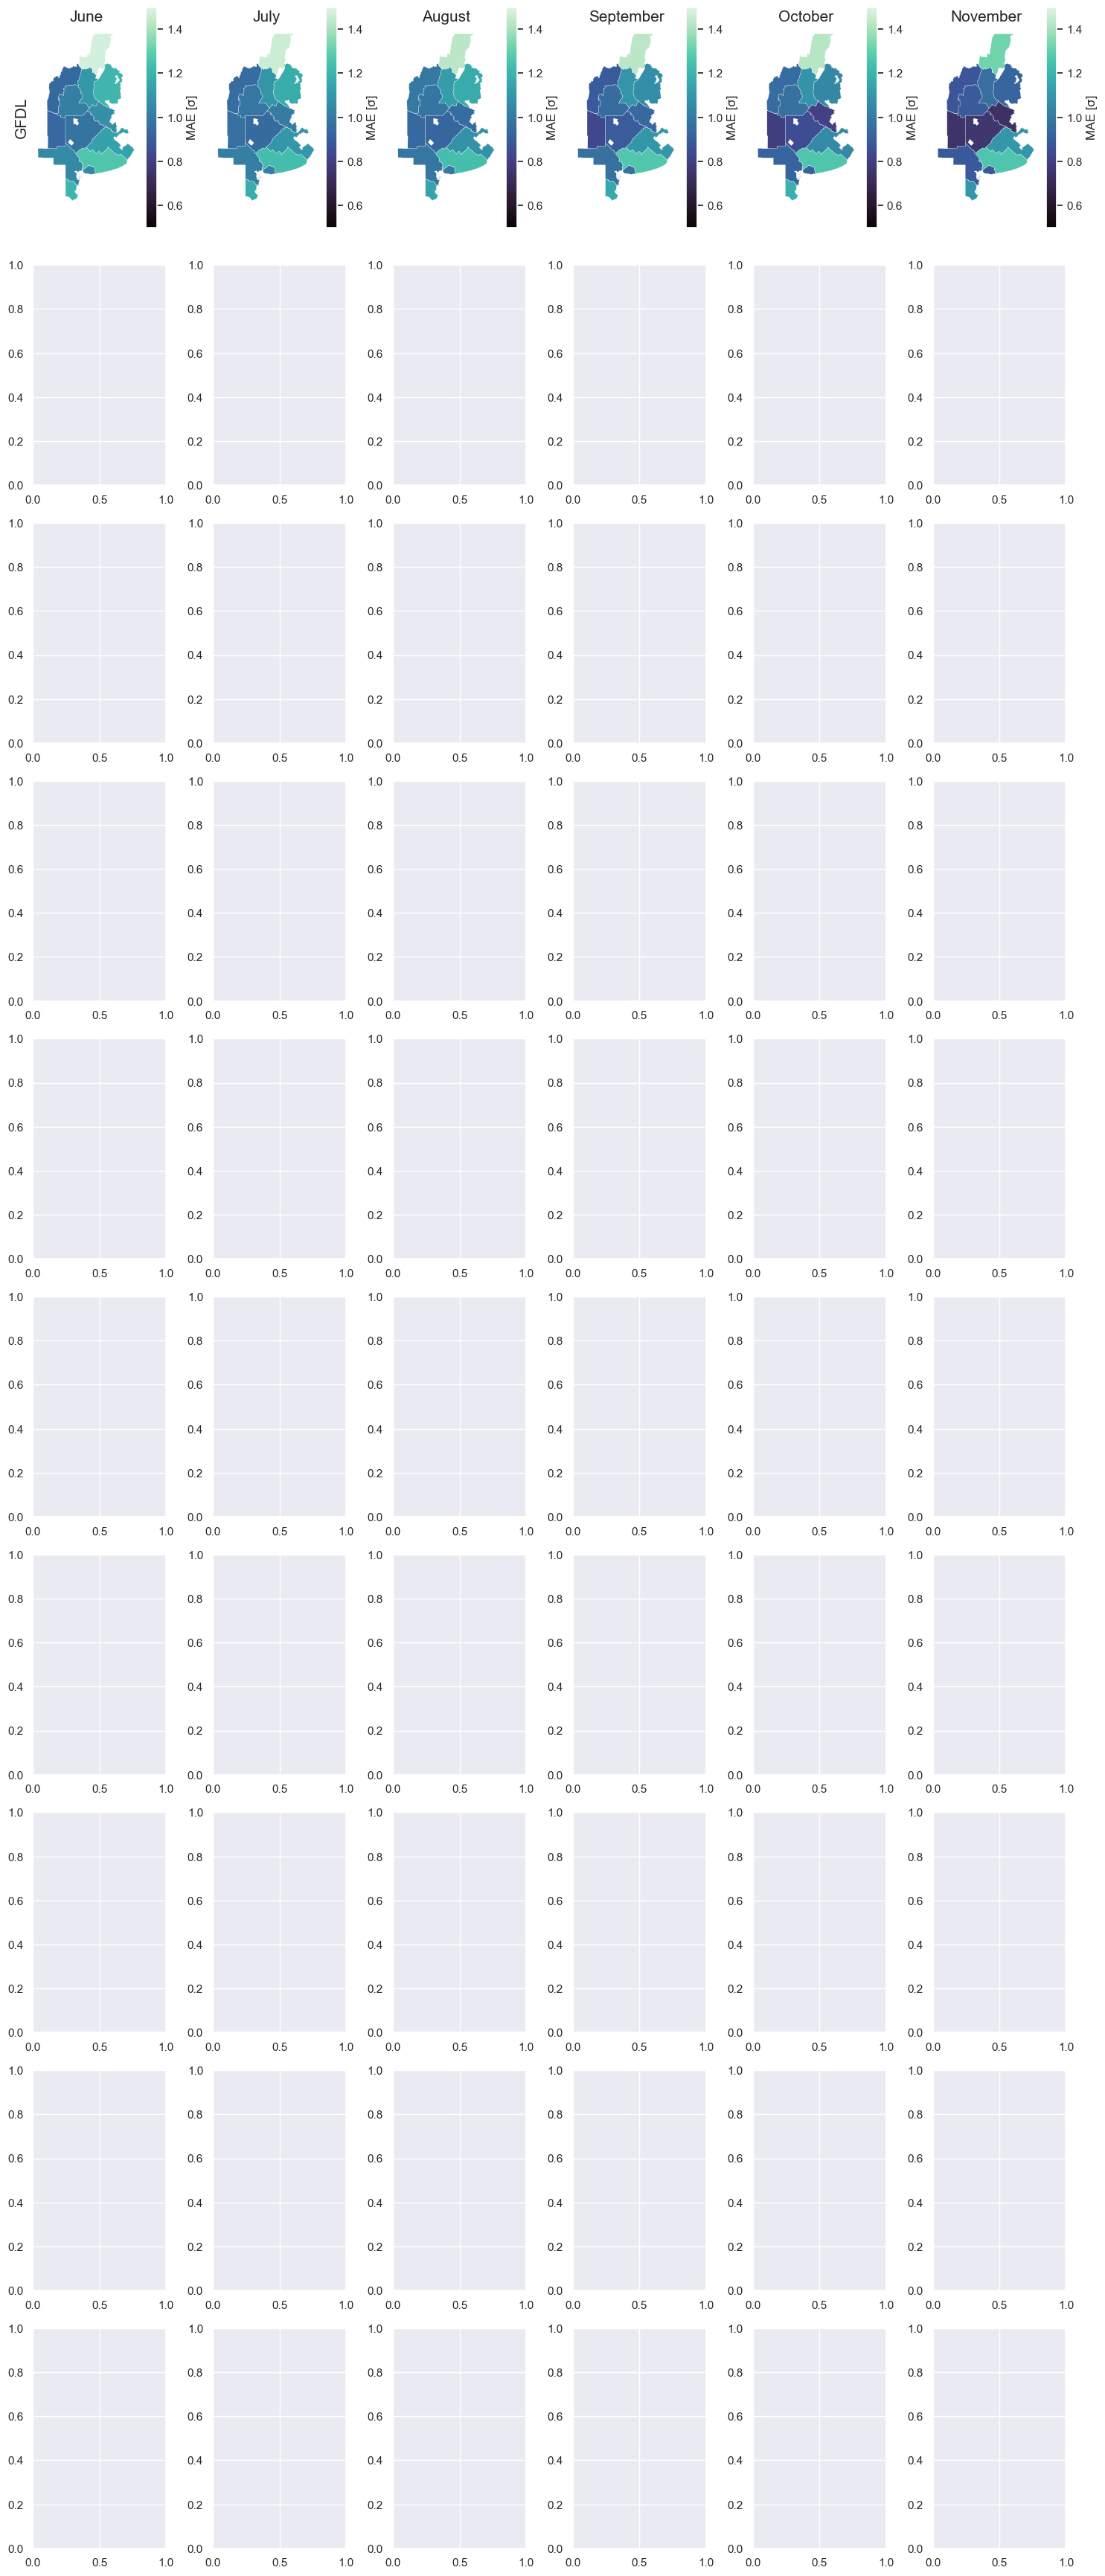

In [ ]:
scm_mae_polygons = gpd.GeoDataFrame(scm_mae.groupby(["model", "region", "init_month"])["MAE"].mean().reset_index().merge(regions_shape[["region", "geometry"]], on="region", how="left"), geometry="geometry", crs="EPSG:4326").set_index(["model", "init_month"]).sort_index()

month_to_name = {6:"June", 7:"July", 8:"August", 9:"September", 10:"October", 11:"November"}
# Create a figure and a set of subplots
fig, axs = plt.subplots(10, 6, figsize=(15, 35))

for i, month in enumerate(range(6, 12)):
    #cb = False if i != 0 else True
    #for j, model in enumerate(scm_mae["model"].unique()):
    for j, model in enumerate(["GFDL"]):
        
        scm_mae_polygons.loc[model, month].plot("MAE", ax=axs[j][i], edgecolor="white", linewidth=.2, vmin=0.5, vmax=1.5, cmap="mako", legend=True, legend_kwds={"label": "MAE [σ]", "orientation": "vertical"})
        #axs[j][i].set_title("UKMO - {}".format(month))
        
        if i == 0:
            axs[j][i].set_ylabel(model, fontsize=15)
        if j == 0:    
            axs[j][i].set_xlabel(month_to_name[month], fontsize=15)    
            axs[j][i].xaxis.set_label_position('top') 
        axs[j][i].spines[['right', 'top', "left", "bottom"]].set_visible(False)
        axs[j][i].set_xticks([])
        axs[j][i].set_yticks([])
        axs[j][i].set_facecolor('white')
        
plt.tight_layout()
#plt.savefig("mae_scm.png")
plt.show()

### Plot mean MAE by month and SCM

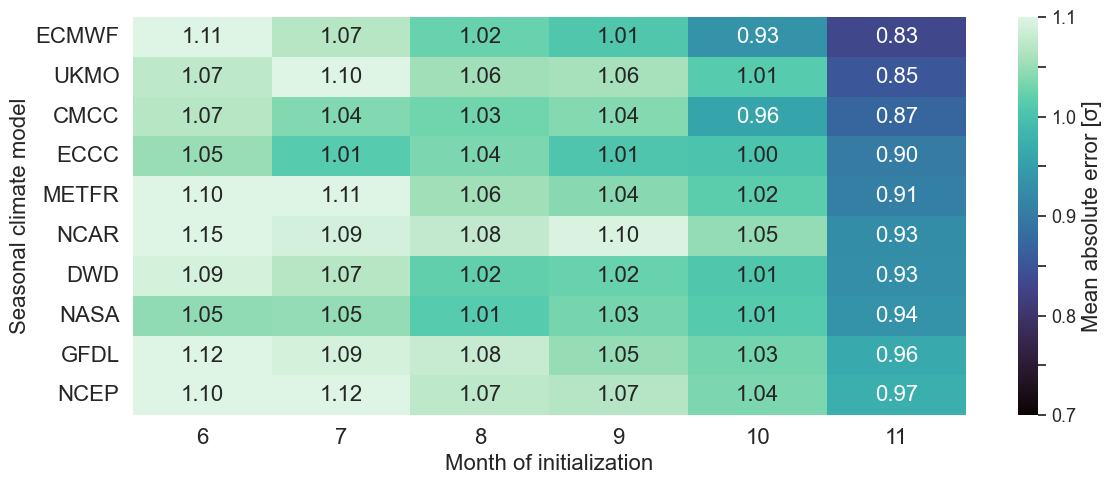

In [12]:
fontsize=16
scm_mae["model"] = scm_mae["model"].replace("CCSM4", "NCAR")
sns.set_theme(rc={'figure.figsize':(12,5)})
scm_mae_plot = scm_mae.groupby(["model", "init_month"])["MAE"].mean().reset_index().pivot_table(index="model", columns="init_month", values="MAE")

ax = sns.heatmap(scm_mae_plot.sort_values(by=11), cmap="mako", cbar=True, vmin=0.7, vmax=1.1, annot=True, fmt=".2f", annot_kws={"size":fontsize})
ax.tick_params(left=False, bottom=False)
#axs.set_title("a) Mean absolute error between forecasted and ERA features [\u03C3]", loc="left", size=fontsize)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=0, ha='center')
ax.set_xlabel("Month of initialization", size=fontsize);
ax.set_ylabel("Seasonal climate model", size=fontsize);
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.collections[0].colorbar.set_label("Mean absolute error [\u03C3]", size=fontsize, loc="center")
ax.collections[0].colorbar.set_ticklabels([.7, "", .8, "", .9, "", 1.0, "", 1.1], size=13)
#ax.set_title("Mean absolute error between ERA and SCM features", loc="left", size=fontsize)

plt.tight_layout()
plt.savefig("figure_6.png")
plt.show()

#### Plot error correlations

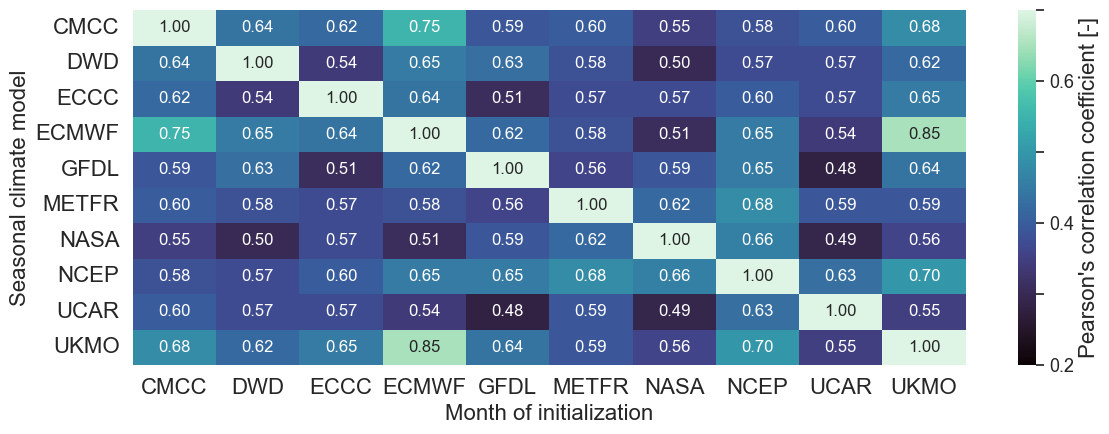

In [16]:
fontsize=16
sns.set_theme(rc={'figure.figsize':(12,4.5)})

df = scm_error.loc[:,:,11].stack().reset_index().rename(columns={0:"error"})[["model", "error"]]
# Adding a row number within each group
df['row_number'] = df.groupby('model').cumcount() + 1
pivot_df = df.pivot(index='row_number', columns='model', values='error').corr().round(2)   


ax = sns.heatmap(pivot_df.astype(float), cmap="mako", cbar=True, vmin=0.4, vmax=0.9, annot=True, fmt=".2f", annot_kws={"size":12})
ax.tick_params(left=False, bottom=False)
#axs.set_title("a) Mean absolute error between forecasted and ERA features [\u03C3]", loc="left", size=fontsize)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=0, ha='center')
ax.set_xlabel("Month of initialization", size=fontsize);
ax.set_ylabel("Seasonal climate model", size=fontsize);
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.collections[0].colorbar.set_label("Pearson's correlation coefficient [-]", size=fontsize, loc="center")
#ax.set_title("Pearson's correlation between forecast errors in November", loc="left", size=fontsize)
ax.collections[0].colorbar.set_ticklabels([.2, "", .4, "", .6, "", .8], size=13)

plt.tight_layout()
plt.savefig("figure_S5.png")
plt.show()

### Build MME

In [18]:
li = []
mean_mme = ["ECMWF", "CMCC", "UKMO", "ECCC", "METFR", "DWD", "NASA"]
for size in range(2, 6):
    for comb in itertools.combinations(mean_mme, size):
        for month in list(range(6, 12)):
            print(comb)
            mean_mme_df = (scm_era.loc[(scm_era["init_month"] == month) & (scm_era["model"].isin(comb))]
                           .groupby(["year", "region", "init_month"])[features_raw].mean().reset_index()
                           .assign(model="MME_{}_{}".format(size, "_".join(list(comb)))))
            li.append(mean_mme_df)
        
scm_era_mme = pd.concat([scm_era, pd.concat(li, ignore_index=True)], ignore_index=True, axis=0)      

('ECMWF', 'CMCC')
('ECMWF', 'CMCC')
('ECMWF', 'CMCC')
('ECMWF', 'CMCC')
('ECMWF', 'CMCC')
('ECMWF', 'CMCC')
('ECMWF', 'UKMO')
('ECMWF', 'UKMO')
('ECMWF', 'UKMO')
('ECMWF', 'UKMO')
('ECMWF', 'UKMO')
('ECMWF', 'UKMO')
('ECMWF', 'ECCC')
('ECMWF', 'ECCC')
('ECMWF', 'ECCC')
('ECMWF', 'ECCC')
('ECMWF', 'ECCC')
('ECMWF', 'ECCC')
('ECMWF', 'METFR')
('ECMWF', 'METFR')
('ECMWF', 'METFR')
('ECMWF', 'METFR')
('ECMWF', 'METFR')
('ECMWF', 'METFR')
('ECMWF', 'DWD')
('ECMWF', 'DWD')
('ECMWF', 'DWD')
('ECMWF', 'DWD')
('ECMWF', 'DWD')
('ECMWF', 'DWD')
('ECMWF', 'NASA')
('ECMWF', 'NASA')
('ECMWF', 'NASA')
('ECMWF', 'NASA')
('ECMWF', 'NASA')
('ECMWF', 'NASA')
('CMCC', 'UKMO')
('CMCC', 'UKMO')
('CMCC', 'UKMO')
('CMCC', 'UKMO')
('CMCC', 'UKMO')
('CMCC', 'UKMO')
('CMCC', 'ECCC')
('CMCC', 'ECCC')
('CMCC', 'ECCC')
('CMCC', 'ECCC')
('CMCC', 'ECCC')
('CMCC', 'ECCC')
('CMCC', 'METFR')
('CMCC', 'METFR')
('CMCC', 'METFR')
('CMCC', 'METFR')
('CMCC', 'METFR')
('CMCC', 'METFR')
('CMCC', 'DWD')
('CMCC', 'DWD')
('CMCC',

In [20]:
scm_era_mme["model"] = scm_era_mme["model"].replace("CCSM4", "UCAR")

In [21]:
yield_data = pd.read_csv("files/ERA/processed/era_regional.csv", usecols=["year", "region", "yield anomaly [%]", "harvested area loo [ha]"])
scm_era_mme_yield = scm_era_mme.merge(yield_data, on=["year", "region"], how="left")

### EXPORT

In [22]:
scm_era_mme_yield.to_csv("files/ERA/processed/era_scm_final_features_different_MMEs.csv", index=False)